<a href="https://colab.research.google.com/github/hossamhamdy333/AI-Projects-Portfolio/blob/main/machine-learning-projects/life-satisfaction-prediction/life_satisfaction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
!git clone https://github.com/hossamhamdy333/AI-Projects-Portfolio.git

fatal: destination path 'AI-Projects-Portfolio' already exists and is not an empty directory.


In [75]:
import sys
assert sys.version_info >= (3, 7)
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error # the RMSE is more sensitive to outliers
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
import joblib



In [76]:
from pathlib import Path

# Where to save the figures
IMAGES_PATH = (
    Path("/content/AI-Projects-Portfolio")
    / "machine-learning-projects"
    / "life-satisfaction-prediction"
    / "images"
)
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [77]:
# read the data
oecd_bli = pd.read_csv("/content/AI-Projects-Portfolio/machine-learning-projects/life-satisfaction-prediction/data/oecd_bli.csv")
gdp_per_capita = pd.read_csv("/content/AI-Projects-Portfolio/machine-learning-projects/life-satisfaction-prediction/data/gdp_per_capita.csv")


In [78]:
oecd_bli.head()

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,5.4,NaN,NaN
1,AUT,Austria,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.5,NaN,NaN
2,BEL,Belgium,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.7,NaN,NaN
3,CAN,Canada,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,6.0,NaN,NaN
4,CZE,Czech Republic,JE_LMIS,Labour market insecurity,L,Value,TOT,Total,PC,Percentage,0,Units,NaN,NaN,3.1,NaN,NaN


In [79]:
gdp_per_capita.head()

,Entity,Code,Year,"GDP per capita, PPP (constant 2017 international $)"
0,Afghanistan,AFG,2002,1189.784668
1,Afghanistan,AFG,2003,1235.810063
2,Afghanistan,AFG,2004,1200.278013
3,Afghanistan,AFG,2005,1286.793659
4,Afghanistan,AFG,2006,1315.789117


In [80]:
gdp_year = 2020
gdppc_col = "GDP per capita (USD)"
lifesat_col = "Life satisfaction"

gdp_per_capita = gdp_per_capita[gdp_per_capita["Year"] == gdp_year]
gdp_per_capita = gdp_per_capita.drop(["Code", "Year"], axis=1)
gdp_per_capita.columns = ["Country", gdppc_col]
gdp_per_capita.set_index("Country", inplace=True)


gdp_per_capita.head()

,GDP per capita (USD)
Country,
Afghanistan,1978.961579
Africa Eastern and Southern,3387.594670
Africa Western and Central,4003.158913
Albania,13295.410885
Algeria,10681.679297


In [81]:
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

oecd_bli.head()

Indicator,Air pollution,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Feeling safe walking alone at night,Homicide rate,Household net adjusted disposable income,Household net wealth,Housing expenditure,...,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Stakeholder engagement for developing regulations,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,
Australia,5.0,NaN,81.0,13.04,73.0,63.5,1.1,32759.0,427064.0,20.0,...,49126.0,95.0,NaN,85.0,2.7,502.0,14.35,91.0,93.0,21.0
Austria,16.0,0.9,85.0,6.66,72.0,80.6,0.5,33541.0,308325.0,21.0,...,50349.0,92.0,1.6,70.0,1.3,492.0,14.55,80.0,92.0,17.0
Belgium,15.0,1.9,77.0,4.75,63.0,70.1,1.0,30364.0,386006.0,21.0,...,49675.0,91.0,2.2,74.0,2.0,503.0,15.70,89.0,84.0,19.3
Brazil,10.0,6.7,49.0,7.13,61.0,35.6,26.7,NaN,NaN,NaN,...,NaN,90.0,NaN,NaN,2.2,395.0,NaN,79.0,73.0,16.2
Canada,7.0,0.2,91.0,3.69,73.0,82.2,1.3,30854.0,423849.0,22.0,...,47622.0,93.0,2.6,88.0,2.9,523.0,14.56,68.0,91.0,17.3


In [82]:
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                              left_index=True, right_index=True)
full_country_stats.sort_values(by=gdppc_col, inplace=True)
full_country_stats = full_country_stats[[gdppc_col, lifesat_col]]

full_country_stats.head()

,GDP per capita (USD),Life satisfaction
Country,,
South Africa,11466.189672,4.7
Colombia,13441.492952,6.3
Brazil,14063.982505,6.4
Mexico,17887.750736,6.5
Chile,23324.524751,6.5


In [83]:
min_gdp = 23_500
max_gdp = 62_500

country_stats = full_country_stats[(full_country_stats[gdppc_col] >= min_gdp) &
                                   (full_country_stats[gdppc_col] <= max_gdp)]
country_stats.head()

,GDP per capita (USD),Life satisfaction
Country,,
Russia,26456.387938,5.8
Greece,27287.083401,5.4
Turkey,28384.987785,5.5
Latvia,29932.493910,5.9
Hungary,31007.768407,5.6


In [84]:
full_country_stats.shape,country_stats.shape

((36, 2), (27, 2))

In [85]:
country_stats.to_csv( (
    Path("/content/AI-Projects-Portfolio")
    / "machine-learning-projects"
    / "life-satisfaction-prediction"
    / "data"
)/ "lifesat.csv")
full_country_stats.to_csv(  (
    Path("/content/AI-Projects-Portfolio")
    / "machine-learning-projects"
    / "life-satisfaction-prediction"
    / "data"
)/ "lifesat_full.csv")

In [86]:
features=full_country_stats[['GDP per capita (USD)']]

In [87]:
target=full_country_stats["Life satisfaction"]

In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=42

)


In [89]:
num_features=["GDP per capita (USD)"]
num_pipeline=make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)
preprocessing=ColumnTransformer([
    ("num",num_pipeline,num_features)]
)

In [90]:
#select and train a model
lin_reg=make_pipeline(
    preprocessing,
    LinearRegression()
)
lin_reg.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['GDP per capita (USD)'])])),
                ('linearregression', LinearRegression())])

In [91]:
# let us see the preformance on the trainig data
life_satisfaction_pred=lin_reg.predict(X_train)
life_satisfaction_pred

array([6.19310623, 6.47895699, 6.22703336, 8.07854573, 5.61045629,
       5.98461119, 6.9590978 , 6.40764575, 6.57466919, 6.08342793,
       6.26585466, 5.67278118, 6.78519146, 5.69242201, 7.40662408,
       5.81306977, 7.25494063, 6.76980024, 6.88734967, 6.26405611,
       6.73985   , 6.56209607, 6.84783765, 6.10963808, 6.58662036,
       6.14427922, 6.40183084, 6.89820753])

In [92]:
lin_rmse=root_mean_squared_error(y_train,life_satisfaction_pred)
lin_rmse

0.5713962142775882

In [93]:
kn_model=make_pipeline(preprocessing
                       ,KNeighborsRegressor())
kn_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['GDP per capita (USD)'])])),
                ('kneighborsregressor', KNeighborsRegressor())])

In [94]:
kn_pred=kn_model.predict(X_train)
kn_rmse=root_mean_squared_error(y_train,kn_pred)
kn_rmse

0.37477612364869617

In [95]:
decision_tree_model=make_pipeline(
    preprocessing,
    DecisionTreeRegressor( max_depth=5,
    min_samples_leaf=10,
    random_state=42)
)
decision_tree_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['GDP per capita (USD)'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=10,
                                       random_state=42))])

In [96]:
dt_pred=decision_tree_model.predict(X_train)
dt_rmse=root_mean_squared_error(y_train,dt_pred)
dt_rmse

0.41026659785885716

In [97]:
# clean version of trying multible models
models={
    "lin_reg":LinearRegression(),
    "kn":KNeighborsRegressor(),
    "dt":DecisionTreeRegressor( max_depth=5,
    min_samples_leaf=10,
    random_state=42)
}

In [98]:
results = {}
for name, model in models.items():
    pipe = make_pipeline(
         preprocessing,
         model
    )
    pipe.fit(X_train,y_train)

    # evaluate on TRAIN
    y_train_pred = pipe.predict(X_train)
    train_rmse = root_mean_squared_error(y_train, y_train_pred)

    # evaluate on TEST
    y_test_pred = pipe.predict(X_test)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)

    results[name] = {
        "train_rmse": train_rmse,
        "test_rmse": test_rmse
    }

    print(
        f"{name:15s} | "
        f"Train RMSE: {train_rmse:.4f} | "
        f"Test RMSE: {test_rmse:.4f}"
    )



lin_reg         | Train RMSE: 0.5714 | Test RMSE: 0.8120
kn              | Train RMSE: 0.3748 | Test RMSE: 0.4880
dt              | Train RMSE: 0.4103 | Test RMSE: 0.5525


In [99]:
results

{'lin_reg': {'train_rmse': 0.5713962142775882,
  'test_rmse': 0.8120021082995278},
 'kn': {'train_rmse': 0.37477612364869617, 'test_rmse': 0.48800614750226234},
 'dt': {'train_rmse': 0.41026659785885716, 'test_rmse': 0.5525098730007576}}

In [100]:
def plot_learning_curve(model, name, X, y, preprocessing):
    pipe = make_pipeline(preprocessing, model)

    train_sizes, train_scores, val_scores = learning_curve(
        pipe,
        X,
        y,
        cv=5,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )

    # convert from negative RMSE
    train_rmse = -train_scores.mean(axis=1)
    val_rmse = -val_scores.mean(axis=1)

    plt.figure(figsize=(7, 5))
    plt.plot(train_sizes, train_rmse, marker="o", label="Training RMSE")
    plt.plot(train_sizes, val_rmse, marker="s", label="Validation RMSE")

    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.title(f"Learning Curve – {name}")
    plt.legend()
    plt.grid(True)
    save_fig("learning_curves")
    plt.show()


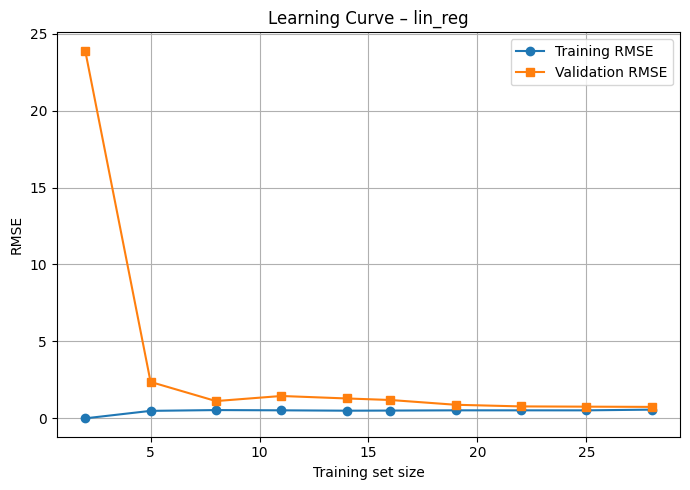

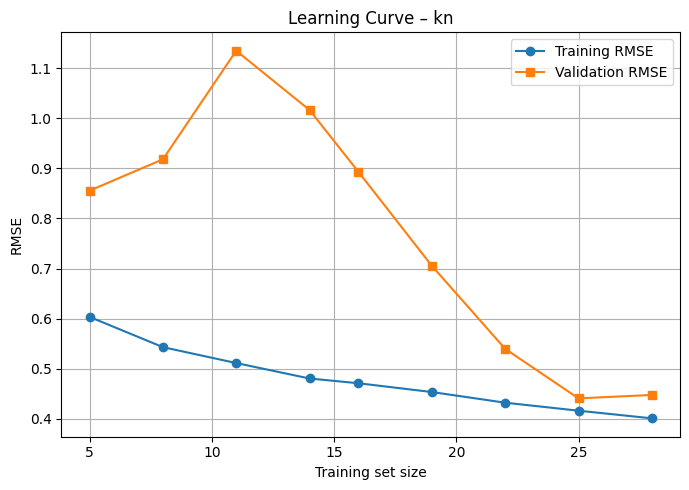

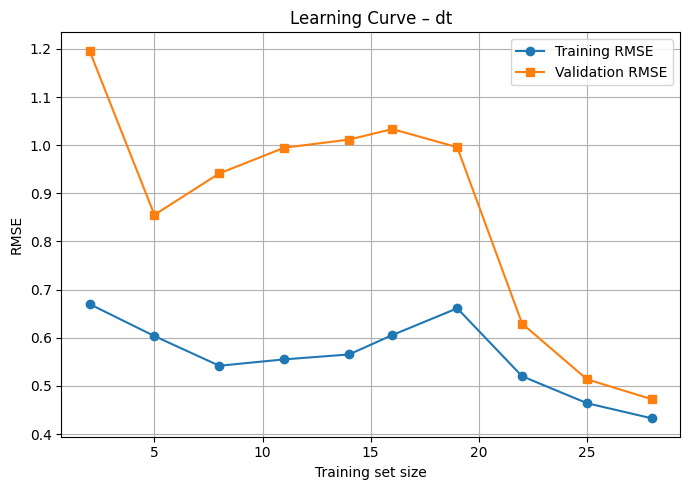

In [101]:
for name, model in models.items():
    plot_learning_curve(
        model=model,
        name=name,
        X=features,
        y=target,
        preprocessing=preprocessing
    )


In [102]:
final_model=make_pipeline(
    preprocessing,
    KNeighborsRegressor()
)
final_model.fit(features,target)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['GDP per capita (USD)'])])),
                ('kneighborsregressor', KNeighborsRegressor())])

In [103]:
joblib.dump(final_model, (
    Path("/content/AI-Projects-Portfolio")
    / "machine-learning-projects"
    / "life-satisfaction-prediction"
    / "models"
)/"life_satisfaction.joblib")

['/content/AI-Projects-Portfolio/machine-learning-projects/life-satisfaction-prediction/models/life_satisfaction.joblib']

In [104]:
model_path = (
    Path("/content/AI-Projects-Portfolio")
    / "machine-learning-projects"
    / "life-satisfaction-prediction"
    / "models"
    / "life_satisfaction.joblib"
)
new_data = pd.DataFrame([[200]],columns=["GDP per capita (USD)"])
loaded_model = joblib.load(model_path)
predictions = loaded_model.predict(new_data)
predictions

array([6.08])